In [98]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [116]:
df = pd.read_csv("dataset_clean.csv")


In [117]:
df.tail()

,timestamp,custID
1992,18-07-2022,11430
1993,19-07-2022,13902
1994,20-07-2022,13404
1995,21-07-2022,12642
1996,22-07-2022,11713


In [118]:
df['DateTime'] = [dt.datetime.strptime(d, "%d-%m-%Y") for d in df["timestamp"]]

# extracting date from timestamp
df['Date'] = [dt.datetime.date(d) for d in df['DateTime']] 


In [119]:
df['Date'] = pd.to_datetime(df['Date'], errors ='coerce')
#df.astype('int64').dtypes
df['weekNumber'] = df['Date'].dt.week
df

C:\Users\akankshadeep\AppData\Local\Temp\ipykernel_5092\2537063532.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekNumber'] = df['Date'].dt.week


,timestamp,custID,DateTime,Date,weekNumber
0,19-01-2017,8578,2017-01-19,2017-01-19,3
1,20-01-2017,8698,2017-01-20,2017-01-20,3
2,21-01-2017,8147,2017-01-21,2017-01-21,3
3,22-01-2017,8359,2017-01-22,2017-01-22,3
4,23-01-2017,7484,2017-01-23,2017-01-23,4
...,...,...,...,...,...
1992,18-07-2022,11430,2022-07-18,2022-07-18,29
1993,19-07-2022,13902,2022-07-19,2022-07-19,29
1994,20-07-2022,13404,2022-07-20,2022-07-20,29
1995,21-07-2022,12642,2022-07-21,2022-07-21,29


In [120]:
df.set_index('custID', inplace=True)

df['CohortGroup'] = df.groupby(level=0)['Date'].min().apply(lambda x: x.week)
df.reset_index(inplace=True)
df.head(100)

,custID,timestamp,DateTime,Date,weekNumber,CohortGroup
0,8578,19-01-2017,2017-01-19,2017-01-19,3,3
1,8698,20-01-2017,2017-01-20,2017-01-20,3,3
2,8147,21-01-2017,2017-01-21,2017-01-21,3,3
3,8359,22-01-2017,2017-01-22,2017-01-22,3,3
4,7484,23-01-2017,2017-01-23,2017-01-23,4,4
...,...,...,...,...,...,...
95,5250,24-04-2017,2017-04-24,2017-04-24,17,17
96,8063,25-04-2017,2017-04-25,2017-04-25,17,17
97,7389,26-04-2017,2017-04-26,2017-04-26,17,17
98,7825,27-04-2017,2017-04-27,2017-04-27,17,17


In [121]:
grouped = df.groupby(['CohortGroup', 'weekNumber'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'custID': pd.Series.nunique})

In [122]:
cohorts

custID
CohortGroup weekNumber        
1           1               32
            3                1
            5                1
            18               1
2           2               31
...                        ...
52          20               1
            52              30
53          22               1
            42               1
            53               5

[360 rows x 1 columns]

In [123]:
# make the column names more meaningful
cohorts.rename(columns={'custID': 'TotalUsers'}, inplace=True)

In [124]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  CohortPeriod
CohortGroup weekNumber                          
1           1                   32             0
            3                    1             1
            5                    1             2
            18                   1             3
2           2                   31             0

In [125]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
1    32
2    31
3    30
4    39
5    36
Name: TotalUsers, dtype: int64

In [126]:
cohorts['TotalUsers'].head()

CohortGroup  CohortPeriod
1            0               32
             1                1
             2                1
             3                1
2            0               31
Name: TotalUsers, dtype: int64

In [127]:
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,53
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
0,32.0,31.0,30.0,39.0,36.0,37.0,1.0,39.0,36.0,41.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,36.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,30.0,1.0,1.0,1.0,1.0,27.0,1.0,NaN
4,NaN,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,29.0,1.0,1.0,1.0,1.0,1.0,27.0,NaN,30.0,NaN


In [128]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,1,2,3,4,5,6,7,8,9,10,...,44,45,46,47,48,49,50,51,52,53
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
0,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.00000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.03125,0.032258,0.033333,0.025641,0.027778,0.027027,36.0,0.025641,0.027778,0.02439,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.03125,0.032258,0.033333,0.025641,0.027778,0.027027,1.0,0.025641,0.027778,0.02439,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0
3,0.03125,0.032258,0.033333,0.025641,0.027778,0.027027,1.0,0.025641,0.027778,0.02439,...,1.0,1.0,30.0,1.0,1.0,1.0,1.0,27.0,1.0,NaN
4,NaN,0.064516,0.033333,0.025641,0.027778,0.027027,2.0,0.025641,0.027778,0.02439,...,29.0,1.0,1.0,1.0,1.0,1.0,27.0,NaN,30.0,NaN
5,NaN,0.032258,NaN,0.025641,0.055556,0.027027,1.0,NaN,0.027778,0.02439,...,1.0,27.0,NaN,28.0,1.0,1.0,NaN,NaN,NaN,NaN
6,NaN,0.032258,NaN,0.025641,0.027778,0.027027,1.0,NaN,NaN,0.02439,...,NaN,1.0,NaN,1.0,30.0,29.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.025641,0.027778,0.027027,1.0,NaN,NaN,0.02439,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,0.027778,NaN,1.0,NaN,NaN,0.04878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


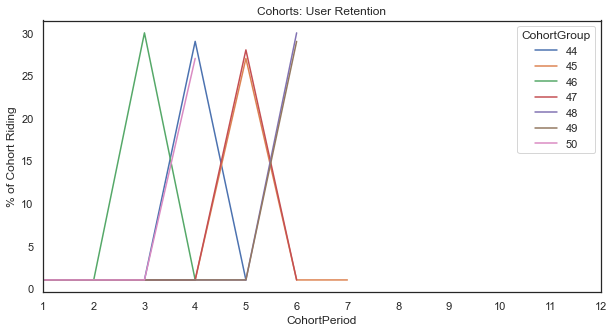

In [130]:
user_retention[[44, 45, 46,47,48,49,50]].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Riding');

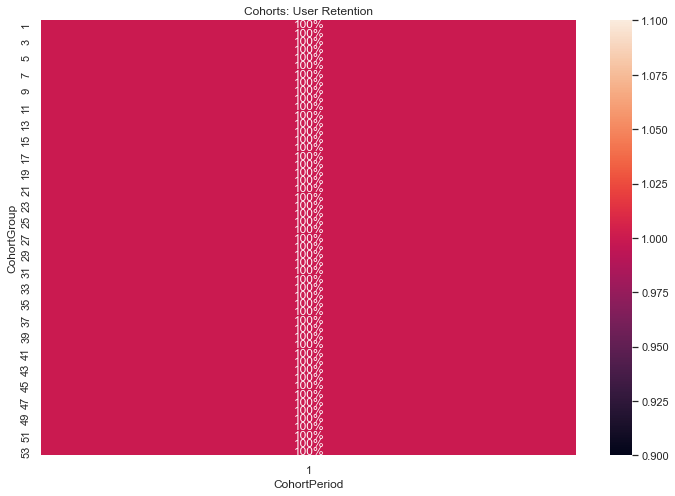

In [100]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');
